# Clustering of Countries 

1. Data Understanding and Cleaning
2. Data Preparation
3. Modelling

In [1]:
#import all the necessary libraries

import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# Data Understanding

In [2]:
#let's read the dataset
dat = pd.read_csv('Country-data.csv')
dat.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Let's convert imports, exports and health spending from  percentage values to actual values of their GDP per capita. Because the percentage values don't give a clear picture of that country. 
For eg. Afghanistan and Albania have similar imports percentage but their gdpp has a huge gap which doesn't give an accurate idea of which country is more developed than the other.

In [3]:
#Converting exports,imports and health spending percentages to absolute values.
dat['exports'] = dat['exports']*dat['gdpp']/100
dat['imports'] = dat['imports']*dat['gdpp']/100
dat['health'] = dat['health']*dat['gdpp']/100

In [4]:
dat.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [5]:
dat.shape

(167, 10)

In [6]:
#basic data checks
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
#basic data cleaning checks
dat.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

# Data Preparation

<Axes: >

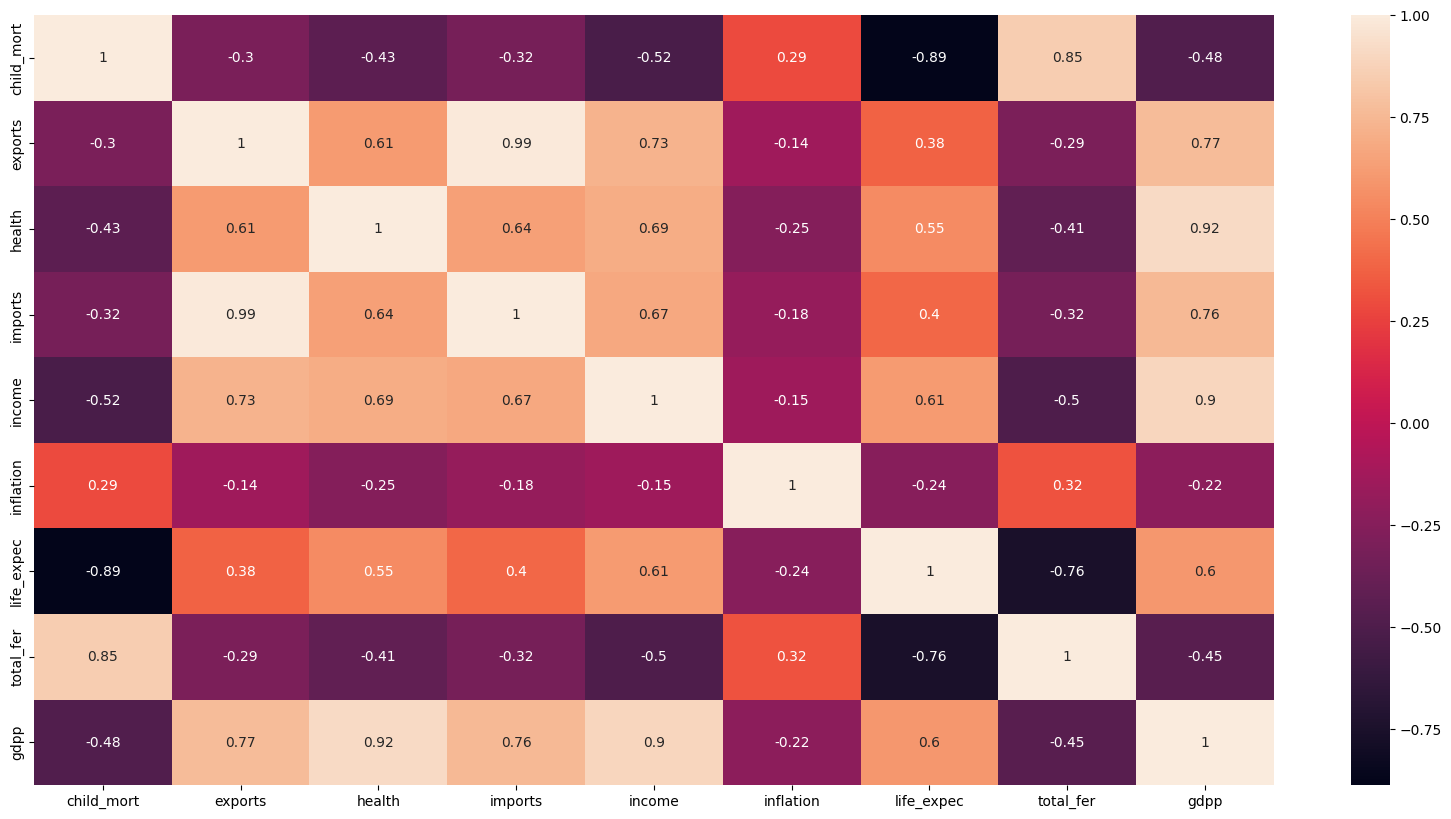

In [8]:
#So this data seems largely clean, but we have a lot of variables and making proper clusters will be a difficulty.
#First let's plot the correlation matrix and check if the data is indeed highly correlated
plt.figure(figsize = (20,10))        
sns.heatmap(dat.corr(),annot = True)

A lot of highly correlated variables exist, hence we need to reduce the number of variables. 
Now let's proceed to doing it on the dataset. We observe that a lot of the data variables are of different orders of magnitude. So we will rescale them before we go ahead with reduction in variables.

In [9]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
datm = standard_scaler.fit_transform(dat.drop(['country'],axis=1))
datm = pd.DataFrame(datm)
datm.columns =['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
print(datm)

     child_mort   exports    health   imports    income  inflation  \
0      1.291532 -0.411011 -0.565040 -0.432276 -0.808245   0.157336   
1     -0.538949 -0.350191 -0.439218 -0.313677 -0.375369  -0.312347   
2     -0.272833 -0.318526 -0.484826 -0.353720 -0.220844   0.789274   
3      2.007808 -0.291375 -0.532363 -0.345953 -0.585043   1.387054   
4     -0.695634 -0.104331 -0.178771  0.040735  0.101732  -0.601749   
..          ...       ...       ...       ...       ...        ...   
162   -0.225578 -0.336864 -0.501562 -0.342488 -0.738527  -0.489784   
163   -0.526514 -0.199393 -0.219310 -0.287205 -0.033542   3.616865   
164   -0.372315 -0.361463 -0.538488 -0.377572 -0.658404   0.409732   
165    0.448417 -0.392166 -0.550596 -0.418479 -0.658924   1.500916   
166    1.114951 -0.383952 -0.540498 -0.418445 -0.721358   0.590015   

     life_expec  total_fer      gdpp  
0     -1.619092   1.902882 -0.679180  
1      0.647866  -0.859973 -0.485623  
2      0.670423  -0.038404 -0.465376  
3  

We will use VIF iteratively and manually reduce the number of variables before clustering, as the number of features is less than 10.

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(datm):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = datm.columns
    vif["VIF"] = [variance_inflation_factor(datm.values, i) for i in range(datm.shape[1])]

    return(vif)

In [11]:
calc_vif(datm)

,variables,VIF
0,child_mort,7.294127
1,exports,116.652517
2,health,18.818141
3,imports,101.647811
4,income,14.906308
5,inflation,1.200193
6,life_expec,6.006097
7,total_fer,3.896214
8,gdpp,49.647627


Since VIF is greater than 5 for exports, we will drop that variable from the analysis.

In [12]:
datm = datm.iloc[:,[1,0,2,3,4,5,6,7,8]]
datm = datm.iloc[:,1:]
calc_vif(datm)

,variables,VIF
0,child_mort,7.291253
1,health,15.733260
2,imports,2.605620
3,income,13.106089
4,inflation,1.172755
5,life_expec,5.788959
6,total_fer,3.768304
7,gdpp,46.921736


Since VIF is greater than 5 for gdpp, we will drop that variable from the analysis.

In [13]:
datm = datm.iloc[:,0:-1]
calc_vif(datm)

,variables,VIF
0,child_mort,7.283204
1,health,2.369601
2,imports,2.070272
3,income,2.802828
4,inflation,1.168983
5,life_expec,5.775690
6,total_fer,3.706232


Since VIF is greater than 5 for child_mort, we will drop that variable from the analysis.

In [14]:
datm = datm.iloc[:,1:]
calc_vif(datm)

,variables,VIF
0,health,2.337106
1,imports,2.068871
2,income,2.802648
3,inflation,1.161083
4,life_expec,2.995426
5,total_fer,2.528805


Now the VIF for all the remaining variables is less than 5.

In [15]:
#Let's create a new matrix according to the scaled values of the final variables
dcon = pd.concat([dat.loc[:,"country"],datm],axis=1)
dcon.head()

,country,health,imports,income,inflation,life_expec,total_fer
0,Afghanistan,-0.565040,-0.432276,-0.808245,0.157336,-1.619092,1.902882
1,Albania,-0.439218,-0.313677,-0.375369,-0.312347,0.647866,-0.859973
2,Algeria,-0.484826,-0.353720,-0.220844,0.789274,0.670423,-0.038404
3,Angola,-0.532363,-0.345953,-0.585043,1.387054,-1.179234,2.128151
4,Antigua and Barbuda,-0.178771,0.040735,0.101732,-0.601749,0.704258,-0.541946


In [16]:
#Let's do the outlier analysis before proceeding to clustering
#We can reassign the outliers to the clusters later.
Qa = dcon.health.quantile(0.025)
Qb = dcon.health.quantile(0.975)
dcon = dcon[(dcon.health >= Qa) & (dcon.health <= Qb)]

In [17]:
Qa = dcon.imports.quantile(0.025)
Qb = dcon.imports.quantile(0.975)
dcon = dcon[(dcon.imports >= Qa) & (dcon.imports <= Qb)]

In [18]:
Qa = dcon.income.quantile(0.025)
Qb = dcon.income.quantile(0.975)
dcon = dcon[(dcon.income >= Qa) & (dcon.income <= Qb)]

In [19]:
Qa = dcon.inflation.quantile(0.025)
Qb = dcon.inflation.quantile(0.975)
dcon = dcon[(dcon.inflation >= Qa) & (dcon.inflation <= Qb)]

In [20]:
Qa = dcon.life_expec.quantile(0.025)
Qb = dcon.life_expec.quantile(0.975)
dcon = dcon[(dcon.life_expec >= Qa) & (dcon.life_expec <= Qb)]

In [21]:
Qa = dcon.total_fer.quantile(0.025)
Qb = dcon.total_fer.quantile(0.975)
dcon = dcon[(dcon.total_fer >= Qa) & (dcon.total_fer <= Qb)]

In [22]:
#Outlier analysis is now done. Let's check the data again.
rows = list(dcon.index)
dcon.rename(index={rows[i]:(i+1) for i in range(len(rows))}, inplace=True)
dcon.shape

(117, 7)

Out of 167 countries, 117 of them are remaining in our dataset after outlier analysis.

## Clustering

As we checked previously the dataset looks of similar magnitude. Hence no further standardisation is necessary.
Let's proceed to calculating the Hopkins statistic to ensure that the data is good for clustering.


In [23]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [24]:
#Let's check the Hopkins measure
X = dcon.drop(['country'],axis=1)
hopkins(X)

0.8284638475829533

0.83 is a good Hopkins score. Hence the data is suitable for clustering. Preliminary check is now done.

### K-Means Clustering

In [25]:
#Let's check the Silhouette Score first to identify the ideal number of clusters
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(X)
    sse_.append([k, silhouette_score(X, kmeans.labels_)])

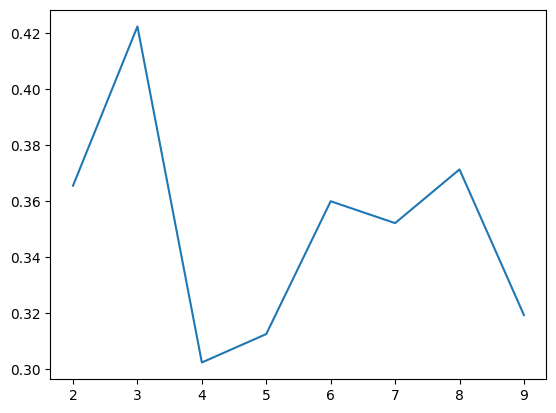

In [26]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

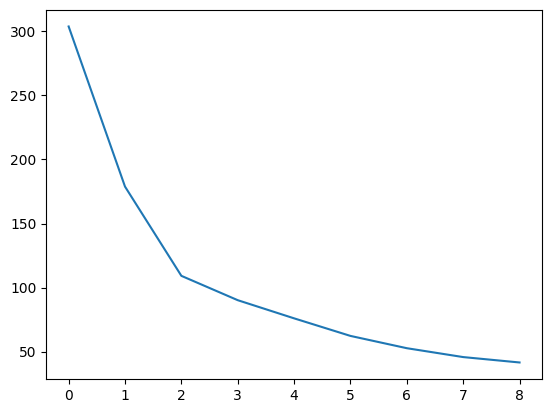

In [27]:
#The Sihouette Score reaches a peak at around 3 clusters indicating that it might be the ideal number of clusters.
#Let's use the elbow curve method to identify the ideal number of clusters.
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(X)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [28]:
# A distinct elbow is formed at around 1-6 clusters. 
# Let's finally create the clusters and see for ourselves which ones fare better.
# We will choose 5 for the number of clusters as after the point k=5, the curve decreases in a linear fashion.
# K-means with k=5 clusters
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(X)

KMeans(max_iter=50, n_clusters=5)

In [29]:
dat4=dcon
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus5.labels_)], axis=1)
dat_km.rename(columns = {0: "ClusterID"}, inplace = True)
dat_km.head()

,country,health,imports,income,inflation,life_expec,total_fer,ClusterID
0,Afghanistan,-0.565040,-0.432276,-0.808245,0.157336,-1.619092,1.902882,3
1,Albania,-0.439218,-0.313677,-0.375369,-0.312347,0.647866,-0.859973,2
2,Algeria,-0.484826,-0.353720,-0.220844,0.789274,0.670423,-0.038404,4
3,Antigua and Barbuda,-0.178771,0.040735,0.101732,-0.601749,0.704258,-0.541946,2
4,Argentina,-0.123849,-0.336841,0.080920,1.244725,0.591474,-0.382933,4


In [30]:
dat_km['ClusterID'].value_counts()

2    45
3    22
0    21
4    16
1    13
Name: ClusterID, dtype: int64

<Axes: xlabel='imports', ylabel='inflation'>

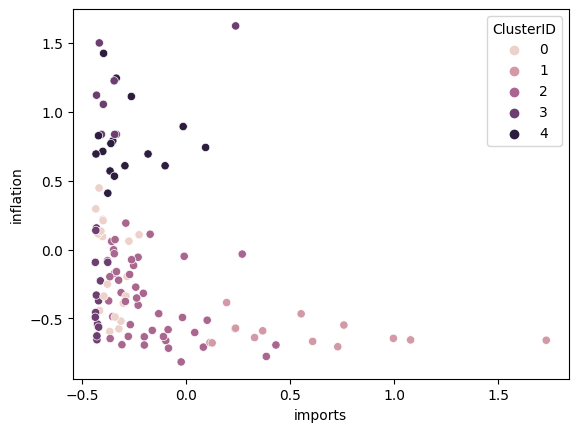

In [31]:
#Each cluster has a good number of countries associated with it (at least 5% of the dataset under consideration)
#Let's do some further visualizations.
#We'll be visualising the clusters on 'imports', 'inflation', and 'health'.
sns.scatterplot(x='imports',y='inflation',hue='ClusterID',legend='full',data=dat_km)

<Axes: xlabel='inflation', ylabel='health'>

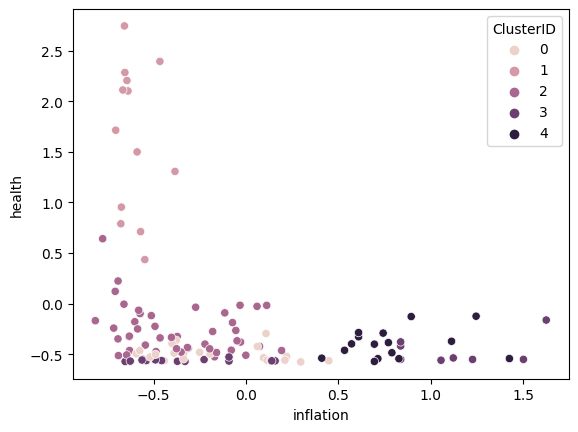

In [32]:
sns.scatterplot(x='inflation',y='health',hue='ClusterID',data=dat_km)

<Axes: xlabel='health', ylabel='imports'>

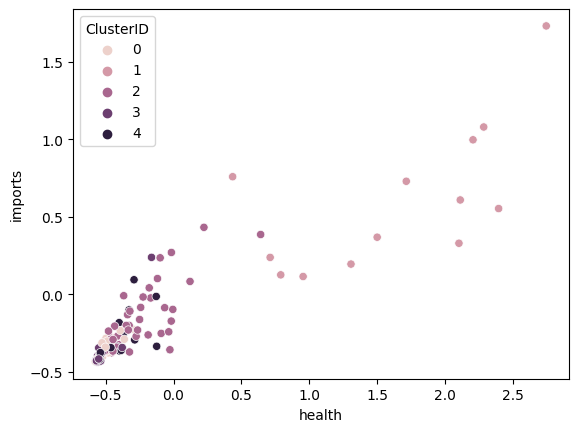

In [33]:
sns.scatterplot(x='health',y='imports',hue='ClusterID',data=dat_km)

In [34]:
#One thing we noticed is some even though some distinct clusters are being formed, some are not so good.
#Now let's create the cluster means w.r.t. to the various variables mentioned in the question and plot to see how they are related.
dat_km1=dat_km[['country', 'ClusterID']]
dat5=pd.merge(dat,dat_km1,on='country')
dat6=dat5[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','ClusterID']]
clu_chi = 	pd.DataFrame(dat6.groupby(["ClusterID"]).child_mort.mean())
clu_exp= 	pd.DataFrame(dat6.groupby(["ClusterID"]).exports.mean())
clu_imp = 	pd.DataFrame(dat6.groupby(["ClusterID"]).imports.mean())
clu_hea = 	pd.DataFrame(dat6.groupby(["ClusterID"]).health.mean())
clu_inc = 	pd.DataFrame(dat6.groupby(["ClusterID"]).income.mean())
clu_inf = 	pd.DataFrame(dat6.groupby(["ClusterID"]).inflation.mean())         
clu_lif = 	pd.DataFrame(dat6.groupby(["ClusterID"]).life_expec.mean())
clu_tot = 	pd.DataFrame(dat6.groupby(["ClusterID"]).total_fer.mean())
clu_gdpp = 	pd.DataFrame(dat6.groupby(["ClusterID"]).gdpp.mean())

df = pd.concat([pd.Series([0,1,2,3,4]),clu_chi,clu_exp,clu_imp,clu_hea,clu_inc,clu_inf,clu_lif,clu_tot,clu_gdpp], axis=1)
df.columns = ["ClusterID", "Child_Mortality", "Exports", "Imports","Health_Spending","Income","Inflation","Life_Expectancy","Total_Fertility","GDPpcapita"]
df

,ClusterID,Child_Mortality,Exports,Imports,Health_Spending,Income,Inflation,Life_Expectancy,Total_Fertility,GDPpcapita
0,0,43.842857,1069.904667,1458.624190,167.608343,5734.761905,6.164762,66.790476,3.302857,2673.523810
1,1,4.323077,15738.907692,15413.138462,3992.779231,36715.384615,1.395154,80.630769,1.810769,39130.769231
2,2,15.673333,3734.125333,4076.865333,582.673533,14279.555556,3.925133,75.106667,1.986667,8357.777778
3,3,81.009091,1299.147136,983.661000,114.050582,4862.727273,9.857500,61.963636,4.955455,2258.818182
4,4,21.506250,3311.860850,2401.538625,339.143188,17514.375000,16.106250,72.256250,2.243125,7237.625000


We observe that child mortality, health spending, life expectancy and GDP per capita are good predictors for the development of a country. Let's visualise the clusters along these.

<Axes: xlabel='child_mort', ylabel='health'>

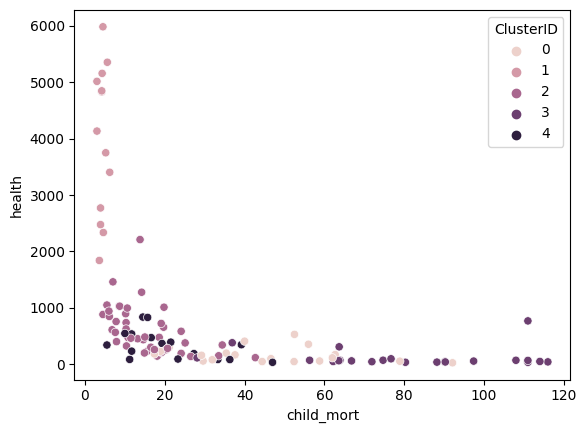

In [38]:
#Along child-mortality and health spending
sns.scatterplot(x='child_mort',y='health',hue='ClusterID',data=dat6)

In [39]:
#let's take a look at those countries clusters and try to make sense if the clustering process worked well.
# Cluster 1 consists of countries which have good development indicators.
dat6[dat6['ClusterID']==1]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
6,Austria,4.3,24059.7,22418.2,5159.00,43200,0.873,80.5,1.44,46900,1
22,Canada,5.6,13793.4,14694.0,5356.20,40700,2.870,81.3,1.63,47400,1
32,Cyprus,3.6,15461.6,17710.0,1838.76,33900,2.010,79.9,1.42,30800,1
40,Finland,3.0,17879.4,17278.8,4134.90,39800,0.351,80.0,1.87,46200,1
41,France,4.2,10880.8,11408.6,4831.40,36900,1.050,81.4,2.03,40600,1
45,Germany,4.2,17681.4,15507.8,4848.80,40400,0.758,80.1,1.39,41800,1
47,Greece,3.9,5944.9,8258.3,2770.70,28700,0.673,80.4,1.48,26900,1
56,Israel,4.6,10710.0,10067.4,2334.78,29600,1.770,81.4,3.03,30600,1
78,Netherlands,4.5,36216.0,31990.8,5985.70,45500,0.848,80.7,1.79,50300,1
79,New Zealand,6.2,10211.1,9436.0,3403.70,32300,3.730,80.9,2.17,33700,1


<Axes: xlabel='income', ylabel='gdpp'>

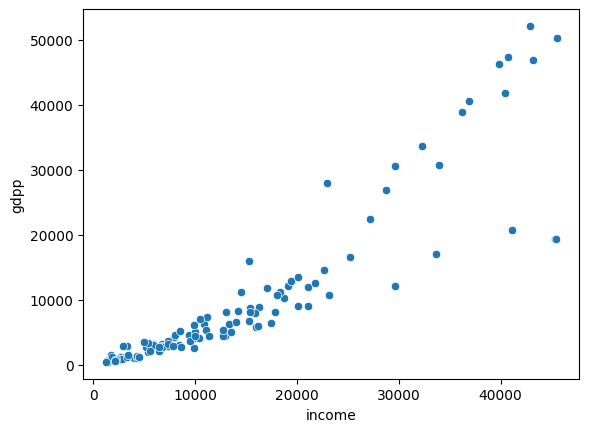

In [41]:
#K-means has done a satisfactory job here. Let's take a different approach and make the clusters only on the basis of these.
sns.scatterplot(x='income',y='gdpp',data=dat6)

###  From the clusters it is observed that cluster 0 and 3 have pretty low values of the six indicators that we chose. Hence these are the countries that we need to focus.

#### Final result : We use the clusters formed during K-Means clustering to find the countries that we require. We conclude that Cluster 0 and 3 might be the ones which has a proper need of aid.

###  Note 1
For outliers that we removed before clustering took place, you can take any approach to include them in the final list of countries that you'd focus on. Either reassign them to the clusters that were formed and see if Cluster 0 and Cluster 3 have any more countries. Or use one variable from some of the main indicators to bin the entire 167 countries. Like if you take GDPP, keep the bin limits as 0-2300, 2300-2700, 2700-7200, 7200-8400 and >8400. The bin limits are decided on the basis of the approximate gdpp means that we got for the 5 clusters. Categorise all the countries from the original dataset within these limits and then take all the countries less than 2300 as the cutoff. Similarly, proceed for the 2nd variable. Any other logically thought out approach also works.

In [56]:
p=dat6[dat6['ClusterID']==3]
print(p.max())
print(p.median())

country         Yemen
child_mort      116.0
exports       14671.8
imports       10071.9
health         766.08
income          33700
inflation        24.9
life_expec       68.2
total_fer        5.87
gdpp            17100
ClusterID           3
dtype: object
child_mort      78.5000
exports        269.9100
imports        375.6365
health          57.8575
income        2330.0000
inflation        6.8100
life_expec      62.0000
total_fer        4.9650
gdpp          1100.0000
ClusterID        3.0000
dtype: float64
